# Monet Painting GAN Project
Author: Grant Novota

## Overview
Goal: to build a Generative Adversarial Network (GAN), specifically a CycleGAN model, capable of generating images in the style of Monet. 

A GAN consists of at least two neural networks: a generator and a discriminator. These two models work against each other--the generator tries to produce realistic images to fool the discriminator, while the discriminator attempts to distinguish between real and generated images.

### Data
The dataset contains two TFRecord files, with all images having three color channels (RGB): 
* **monet_tfrec** - 300 Monet paintings, each sized 256x256 pixels, in TFRecord format
* **photo_tfrec** - 7028 photos, each sized 256x256 pixels, in TFRecord format

**Data Source:** Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import PIL
import shutil

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer, Input, Conv2D, Conv2DTranspose, GroupNormalization 
from keras.layers import Activation, ReLU, LeakyReLU, Add
from keras.optimizers import Adam
from keras.ops import pad, ones_like, zeros_like
from keras.utils import register_keras_serializable
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import ModelCheckpoint

## Exploratory Data Analysis

In [2]:
# Get the file names from monet_tfrec and photo_tfrec
monet_file = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_file = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

As described in Introduction, all images have a resolution of 256×256 pixels with 3 channels (RGB). I will define a function to decode the images from the TFRecord files and scale the pixel values to the range [-1, 1], as this is a common practice when training CycleGAN models.

In [3]:
# Define a function to decode images from TFRecord files
def decode_img(img):
    image = tf.io.decode_jpeg(img, channels = 3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

# Define a function to read images from TFRecord files
def read_tfrecord(tfdata):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    tfdata = tf.io.parse_single_example(tfdata, tfrecord_format)
    image = decode_img(tfdata['image'])
    return image

# Define a function to load images from the TFRecord files
def load_dataset(filenames):
    # disable order, increase speed
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False   
    
    # read images from multiple files if available
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [4]:
# Load the datasets
monet_ds = load_dataset(monet_file).batch(1)
photo_ds = load_dataset(photo_file).batch(1)

Now, let's take a look at the images from each dataset.

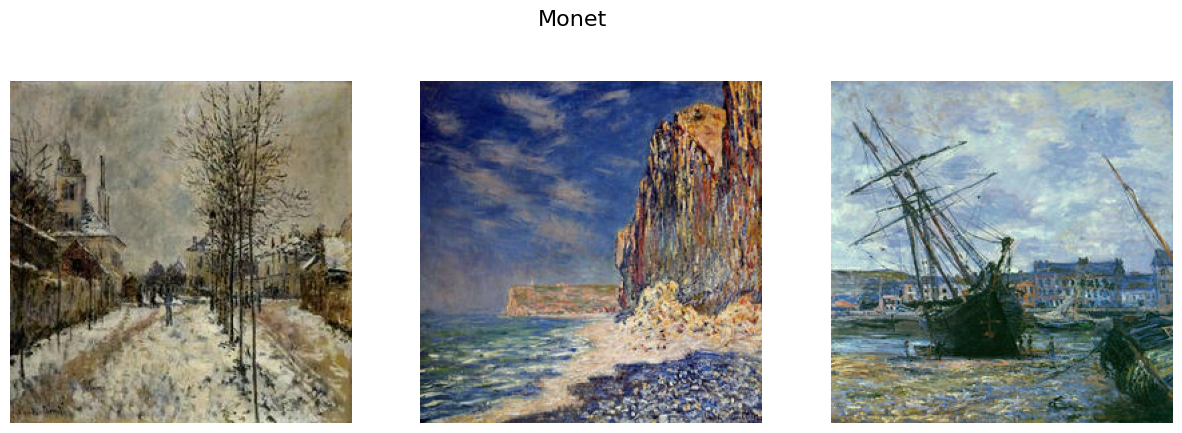

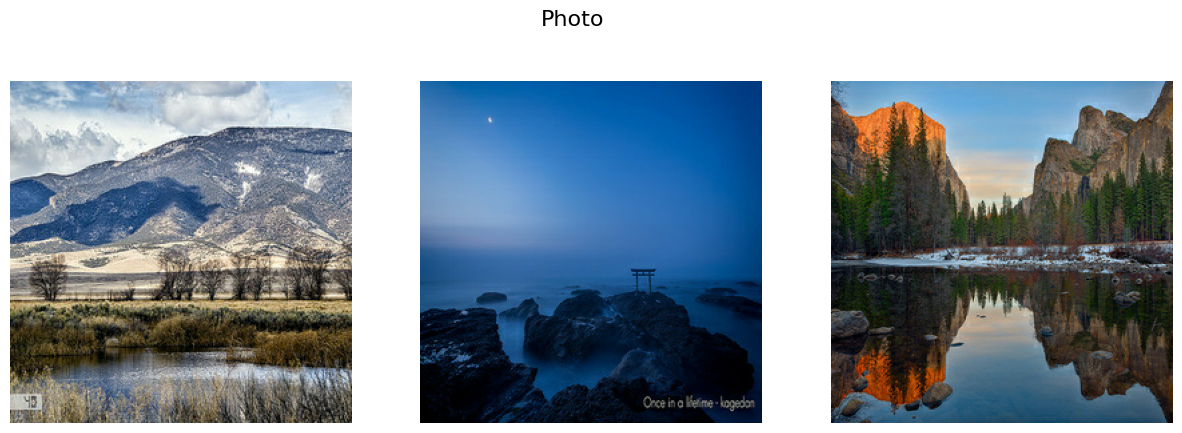

In [5]:
# Plot images from Monet dataset
monets = iter(monet_ds)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
fig.suptitle('Monet', fontsize = 16)
ax = axes.flatten()
for i in range(3):
    monet = next(monets)
    ax[i].imshow(monet[0] * 0.5 + 0.5)
    ax[i].axis('off')
plt.show()

# Plot image from photo dataset
photos = iter(photo_ds)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
fig.suptitle('Photo', fontsize = 16)
ax = axes.flatten()
for i in range(3):
    photo = next(photos)
    ax[i].imshow(photo[0] * 0.5 + 0.5)
    ax[i].axis('off')
plt.show()

Check the histogram of the RGB channels of both Monet paintings and photos, to see if there is any patterns.

In [6]:
# Define a function to load sample images from each file
def sample_imgs(file_path, num = 300):
    images = []
    filenames = [f for f in os.listdir(file_path) if f.endswith('.jpg')][:num]
    for filename in filenames:
        img_path = os.path.join(file_path, filename)
        image = cv.imread(img_path)
        images.append(image)
    return images

# Load 300 images from each file
monet_sample = sample_imgs('/kaggle/input/gan-getting-started/monet_jpg')
photo_sample = sample_imgs('/kaggle/input/gan-getting-started/photo_jpg')

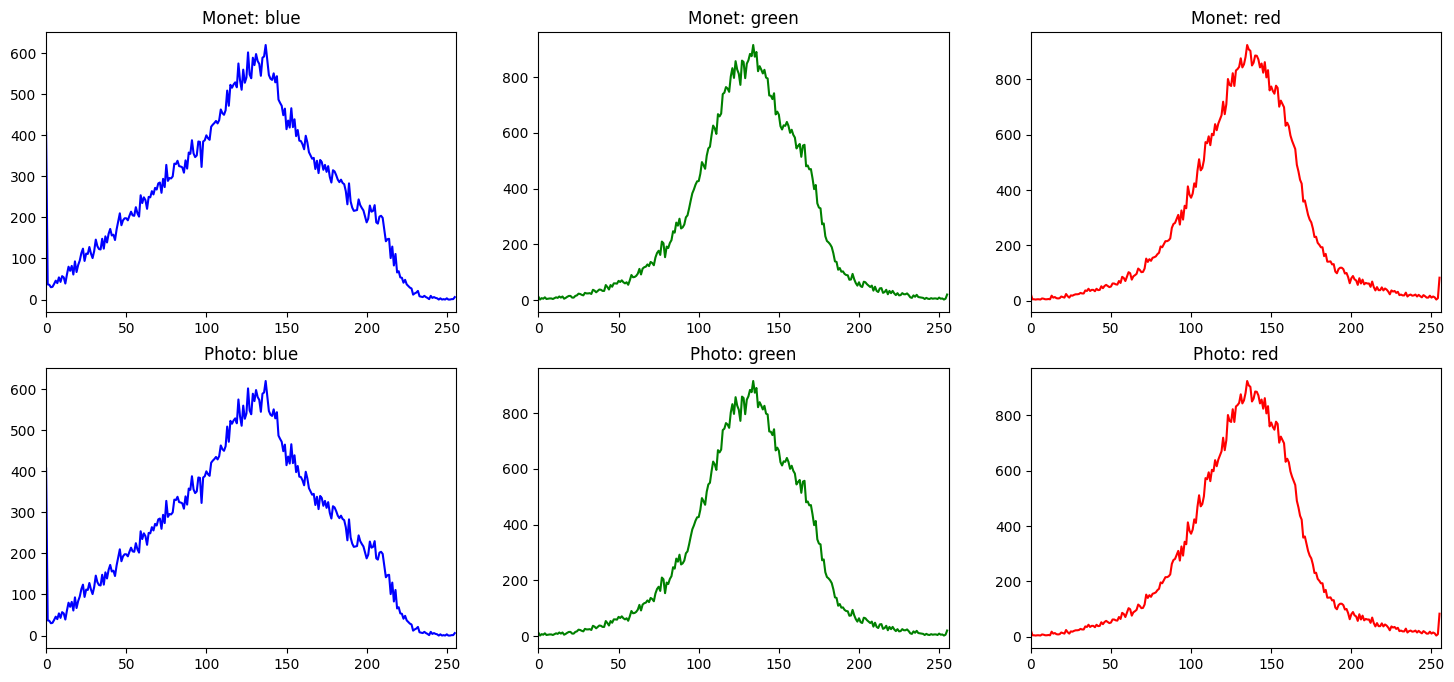

In [7]:
# Plot color histogram
fig,axes = plt.subplots(2, 3, figsize = (18, 8))

colors = ['blue', 'green', 'red']
for i, col in enumerate(colors):
    hist_monet = cv.calcHist(monet_sample, [i], None, [256], [0, 256])
    axes[0, i].plot(hist_monet, color = col)
    axes[0, i].set_xlim([0, 256])
    axes[0, i].set_title(f'Monet: {col}')

    hist_photo = cv.calcHist(photo_sample, [i], None, [256], [0, 256])
    axes[1, i].plot(hist_monet, color = col)
    axes[1, i].set_xlim([0, 256])
    axes[1, i].set_title(f'Photo: {col}')

plt.show()

There is no obvious pattern in the density of the three color channels between Monet paintings and photos.

## Modeling

I will build a CycleGAN model, which is known for unpaired image-to-image translation. For example, it can translate an image of a horse to an image of a zebra, and vice versa.

A CycleGAN model consists of two generators and two discriminators (**the detailed architectures will be described during model building**), and involves three loss functions:
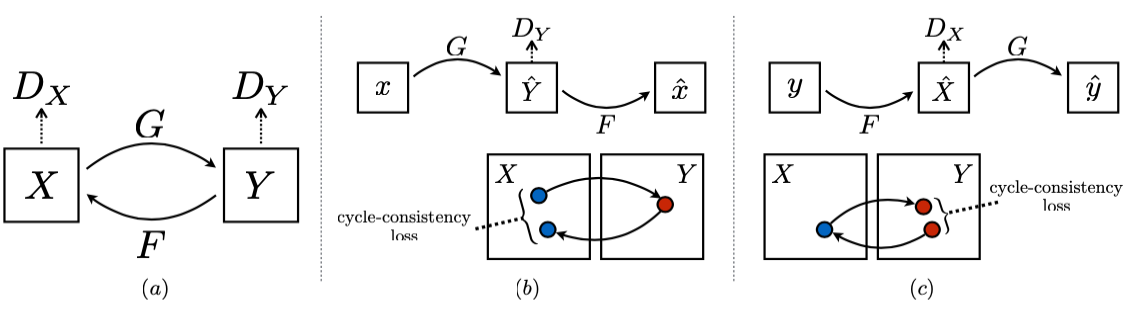

* **Two generators**:  
    1. **Generator G** translates an image X(photo) to Y(Monet); 
    2. **Generator F** translates an image Y(Monet) to X(photo);  
<br>
<br>
* **Two discriminators**:  
    1. **Discriminator Dy** indentifies whether an image is a real Monet painting or not;
    2. **Discriminator Dx** identifies whether an image is a real photo or not;  
<br>
<br> 
* **Three loss functions**:  
    1. **Adversarial loss**: similar to a standard GAN, the discriminators aim to maximize their accuracy in distinguishing real / fake images, while the generators try to fool the discriminators (aiming to minimize discriminators' accuracy in identifying fake images).  
    2. **Cycle consistency loss**: measures the similarity between x and $\hat{x}$, and between y and $\hat{y}$, see the graph (b) and (c) above. The main idea here is that the twice-transformed image $\hat{x}$ (x → $\hat{y}$ → $\hat{x}$) should be similar to the original image x, ensuring that the two generators are consistent with each other. 
    3. **Identity loss**: measures the similarity between x and $\hat{x}$, when x is passed through the generator which is expected to generate x. For example, if a real Monet painting is passed through the generator designed to generate Monet paintings, the outout should remain unchanged. This ensures that the generator does not modify an image when there is no need to.


### Prepare the data for CycleGAN
   
   As we need to train the model on both Monet paintings and photos in each batch, but our images are in two separate datasets--and we only have 300 Monet paintings in monet_dataset while there are over 7000 photos in photo_dataset--I will define a function to `repeat` both datasets indefinitely, `shuffle` them, and then `zip` them together for CycleGAN training.

In [8]:
# Define a function to prepare the data 
def CycleGan_dataset(monet_dataset, photo_dataset):
    monet_ds = monet_dataset.repeat()
    photo_ds = photo_dataset.repeat()
   
    monet_ds = monet_ds.shuffle(2048)
    photo_ds = photo_ds.shuffle(2048)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

# Get the training set 
CycleGan_ds = CycleGan_dataset(monet_ds, photo_ds)

### Build CycleGAN model

**1. Define the building blocks**  

In [9]:
# Weights initializer for the layers
kernel_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

# Weights initializer for the instance normalization
gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

# Define a function for downsampling block
def downsample(x, filters, kernel_size, strides, activation = 'relu'):
    x = Conv2D(filters, kernel_size, strides = strides, padding = 'same',
                     kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = filters, gamma_initializer = gamma_init)(x)    # Instance Normalization
    x = Activation(activation)(x)
    return x

# Define a function for upsampling block
def upsample(x, filters, kernel_size, strides, activation = 'relu'):
    x = Conv2DTranspose(filters, kernel_size, strides = strides, padding = 'same',
                     kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = filters, gamma_initializer = gamma_init)(x)  
    x = Activation(activation)(x)
    return x

# Define a layer of reflection padding via subclassing
@register_keras_serializable()
class reflection_padding(Layer):
    def __init__(self, padding = (1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)
        
    def call(self, input_tensor):
        pad_x, pad_y = self.padding
        pad_width = [
            [0, 0],              # no padding on batch axis
            [pad_y, pad_y],      # padding on image height axis
            [pad_x, pad_x],      # padding on image width axis
            [0, 0]               # no padding on channel axis
        ]
        return pad(input_tensor, pad_width, mode = "reflect")
        
    def get_config(self):
        config = super.get_config()
        config.update({"padding": self.padding})
        return config

# Define a layer of residule block via subclassing
@register_keras_serializable()
class residual_block(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.padding = reflection_padding()

    def build(self, input_shape):
        filters = input_shape[-1]
        self.conv1 = Conv2D(filters, kernel_size = (3, 3), 
                            kernel_initializer = kernel_init, use_bias = False)
        self.conv2 = Conv2D(filters, kernel_size = (3, 3), 
                            kernel_initializer = kernel_init, use_bias = False)
        self.instance_norm1 = GroupNormalization(groups = filters, gamma_initializer = gamma_init)
        self.instance_norm2 = GroupNormalization(groups = filters, gamma_initializer = gamma_init)

    def call(self, inputs):
        input_tensor = inputs
        # first conv block
        x = self.padding(inputs)
        x = self.conv1(x)
        x = self.instance_norm1(x)
        x = Activation('relu')(x)
        
        # second conv block
        x = self.padding(x)
        x = self.conv2(x)
        x = self.instance_norm2(x)
        x = Activation('relu')(x)

        # output
        x = Add()([input_tensor, x])
        return x

    def get_config(self):
        return super.get_config()   

**2. Build the generator**  
The architecture of the generator is as following:  
[c7s1-64] -[d128] - [d256] - [R256] × 9 - [u128] - [u64] - [c7s1-3]  

* **[c7s1-64]**: 7 × 7 Convolution-InstanceNormalization- ReLU layer with 64 filters and stride 1
* **[d128]-[d256]**: downsampling blocks, one with 128 filters and the other with 256 filters
* **[R256]×9**: 9 residual blocks, each with 256 filters
* **[u128]-[u64]**: upsampling blocks, one with 128 filters and the other with 64 filters
* **[c7s1-3]**: 7 × 7 Convolution-InstanceNormalization- ReLU layer with 3 filters and stride 1

In [10]:
# Build the generator
def generator(filters = 64, num_downsample = 2, num_residual = 9, 
              num_upsample = 2, name = None):
    inputs = Input(shape = [256, 256, 3])
    # First convolutional block 
    x = reflection_padding(padding = (3, 3))(inputs)
    x = Conv2D(filters, kernel_size = (7, 7), 
               kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = filters, gamma_initializer = gamma_init)(x)
    x = Activation('relu')(x)

    # Downsampling block
    for _ in range(num_downsample):
        filters *= 2
        x = downsample(x, filters, (3, 3), (2, 2), activation = 'relu')

    # Residual block
    for _ in range(num_residual):
        x = residual_block()(x)

    # Upsampling block
    for _ in range(num_upsample):
        filters //= 2
        x = upsample(x, filters, (3, 3), (2, 2), activation = 'relu')

    # Final block
    x = reflection_padding(padding = (3, 3))(x)
    x = Conv2D(3, kernel_size = (7, 7), 
               kernel_initializer = kernel_init, use_bias = False)(x)
    x = GroupNormalization(groups = 3, gamma_initializer = gamma_init)(x)
    x = Activation('tanh')(x)

    return Model(inputs = inputs, outputs = x)

**3. Build the discriminator**  
The architecture of the discriminator is as following:  
[c4s2-64] -[d128] - [d256] - [d512] - [c4s1-1]  

* [c7s1-64]: 4 × 4 Convolution-leaky ReLU layer with 64 filters and stride 2  
* [d128]-[d256]-[d512]: downsampling blocks, with 128, 256, 512 filters respectively  
* [c4s1-1]: 4 × 4 Convolution-leaky ReLU layer with 1 filters and stride 1  

In [11]:
# Build the discriminator
def discriminator(filters = 64, num_downsample = 3, name = None):
    inputs = Input(shape = [256, 256, 3])
    # First convolutional block
    x = Conv2D(filters, kernel_size = (4, 4), strides = (2, 2), padding = 'same',
               kernel_initializer = kernel_init, use_bias = False)(inputs)
    x = Activation('leaky_relu')(x)

    # Downsampling block
    for _ in range(num_downsample):
        filters *= 2
        x = downsample(x, filters, (4, 4), (2, 2), activation = 'leaky_relu')   

    # Final block
    x = Conv2D(1, kernel_size = (4, 4), padding = 'same',
               kernel_initializer = kernel_init, use_bias = False)(x)

    return Model(inputs = inputs, outputs = x)

**4. Define the loss functions**

In [12]:
# Define the functions of adversarial loss
def generator_loss(dis_fake):
    loss_fn = MeanSquaredError()
    return loss_fn(ones_like(dis_fake), dis_fake)

def discriminator_loss(dis_real, dis_fake):
    loss_fn = MeanSquaredError()
    real_loss = loss_fn(ones_like(dis_real), dis_real)
    fake_loss = loss_fn(zeros_like(dis_fake), dis_fake)
    return (real_loss + fake_loss) * 0.5

# Define the function of cycle consistency loss
def cycle_loss(img, cycled_img, Lambda):
    loss_fn = MeanAbsoluteError()
    return Lambda * loss_fn(img, cycled_img)

# Define the function of identity loss
def identity_loss(img, same_img, Lambda):
    loss_fn = MeanAbsoluteError()
    return 0.5 * Lambda *  loss_fn(img, same_img)

**5. Build the CycleGAN model** 

In [13]:
# Build the CycleGAN model via subclassing
class CycleGAN(Model):
    def __init__(self, generator_monet, generator_photo, discriminator_monet, 
                 discriminator_photo, lambda_cycle = 10):
        super().__init__()
        self.GenM = generator_monet
        self.GenP = generator_photo
        self.DisM = discriminator_monet
        self.DisP = discriminator_photo
        self.Lamd = lambda_cycle
        
    def compile(self, 
                genM_optimizer, genP_optimizer, disM_optimizer, disP_optimizer,
                gen_loss, dis_loss, cycle_loss, identity_loss):
        super().compile()
        self.GenM_Opt = genM_optimizer
        self.GenP_Opt = genP_optimizer
        self.DisM_Opt = disM_optimizer
        self.DisP_Opt = disP_optimizer
        self.gen_loss = gen_loss
        self.dis_loss = dis_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent = True) as tape:
            # photo → monet → photo
            fake_monet = self.GenM(real_photo, training = True)
            cycled_photo = self.GenP(fake_monet, training = True)

            # monet → photo → monet
            fake_photo = self.GenP(real_monet, training = True)
            cycled_monet = self.GenM(fake_photo, training = True)

            # identity mapping
            same_monet = self.GenM(real_monet, training = True)
            same_photo = self.GenP(real_photo, training = True)
            
            # discriminator output
            dis_real_monet = self.DisM(real_monet, training = True)
            dis_fake_monet = self.DisM(fake_monet, training = True)
            dis_real_photo = self.DisP(real_photo, training = True)
            dis_fake_photo = self.DisP(fake_photo, training = True)

            # generator adversarial loss
            genM_adver = self.gen_loss(dis_fake_monet)
            genP_adver = self.gen_loss(dis_fake_photo)

            # cycle loss
            cycle_photo = self.cycle_loss(real_photo, cycled_photo, self.Lamd)
            cycle_monet = self.cycle_loss(real_monet, cycled_monet, self.Lamd)
            total_cycle = cycle_photo + cycle_monet

            # identity loss
            genM_identity = self.identity_loss(real_monet, same_monet, self.Lamd)
            genP_identity = self.identity_loss(real_photo, same_photo, self.Lamd)

            # total generator loss
            genM_loss = genM_adver + total_cycle + genM_identity
            genP_loss = genP_adver + total_cycle + genP_identity

            # discriminator loss
            disM_loss = self.dis_loss(dis_real_monet, dis_fake_monet)
            disP_loss = self.dis_loss(dis_real_photo, dis_fake_photo)

        # calculate gradients for generators
        grads_GenM = tape.gradient(genM_loss, self.GenM.trainable_variables)
        grads_GenP = tape.gradient(genP_loss, self.GenP.trainable_variables)
            
        # calculate gradients for discriminators
        grads_DisM = tape.gradient(disM_loss, self.DisM.trainable_variables)
        grads_DisP = tape.gradient(disP_loss, self.DisP.trainable_variables)

        # update weights of generators and discriminators
        self.GenM_Opt.apply_gradients(zip(grads_GenM, self.GenM.trainable_variables))
        self.GenP_Opt.apply_gradients(zip(grads_GenP, self.GenP.trainable_variables))
        self.DisM_Opt.apply_gradients(zip(grads_DisM, self.DisM.trainable_variables))
        self.DisP_Opt.apply_gradients(zip(grads_DisP, self.DisP.trainable_variables))

        return {
            "genM_loss": genM_loss,
            "genP_loss": genP_loss,
            "disM_loss": disM_loss,
            "disP_loss": disP_loss
        }

### Train the CycleGAN model

Train the CycleGAN model on our dataset. I will set a model checkpoint to save the weights in case the runtime is disconnected during long training, and then train the model for 50 epochs first.

In [14]:
# Define model check_point
check_point = ModelCheckpoint(
    filepath = '/kaggle/working/cyclegan1.weights.h5',
    save_weights_only = True
)

In [15]:
# Train the model
CycleGan = CycleGAN(generator_monet = generator(name = 'gen_monet'), 
                    generator_photo = generator(name = 'gen_photo'), 
                    discriminator_monet = discriminator(name = 'dis_monet'), 
                    discriminator_photo = discriminator(name = 'dis_photo'))
    
CycleGan.compile(genM_optimizer = Adam(learning_rate = 0.0002), 
                 genP_optimizer = Adam(learning_rate = 0.0002), 
                 disM_optimizer = Adam(learning_rate = 0.0002), 
                 disP_optimizer = Adam(learning_rate = 0.0002),
                 gen_loss = generator_loss, 
                 dis_loss = discriminator_loss, 
                 cycle_loss = cycle_loss, 
                 identity_loss = identity_loss)

CycleGan.fit(CycleGan_ds, 
            steps_per_epoch = 300,
            epochs = 50,
            callbacks = [check_point])

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 219s 272ms/step - disM_loss: 0.0679 - disP_loss: 0.0698 - genM_loss: 11.1103 - genP_loss: 11.5427
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 273ms/step - disM_loss: 0.0129 - disP_loss: 0.0150 - genM_loss: 10.5531 - genP_loss: 10.8385
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0213 - disP_loss: 0.0123 - genM_loss: 9.9765 - genP_loss: 10.4574
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0385 - disP_loss: 0.0287 - genM_loss: 9.3544 - genP_loss: 9.7278
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.0923 - disP_loss: 0.0227 - genM_loss: 8.9284 - genP_loss: 9.4696
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - disM_loss: 0.1077 - disP_loss: 0.0417 - genM_loss: 8.7298 - genP_loss: 9.1286
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - disM_loss: 0.1111 - disP_loss: 0.0585 - genM_loss: 8.1230 - genP_loss: 8.5678
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms

## Results and Conclusion

As we can see from the training log above, the generators' loss is much larger than that of the discriminators. This is because we used different loss functions for these two types of models: while the discriminator's loss calculation is based solely on the adversarial loss, the generator's loss calculation involves three loss functions (adversarial loss, cycle consistency loss, and identity loss).  
  
Both discriminators' losses started around 0.067, fluctuated over the 50 epochs, and ended at 0.0588 and 0.0935, respectively. Meanwhile, both generators' losses started around 11 and ended around 5.8 at epoch 50, showing a relatively stable improvement.  

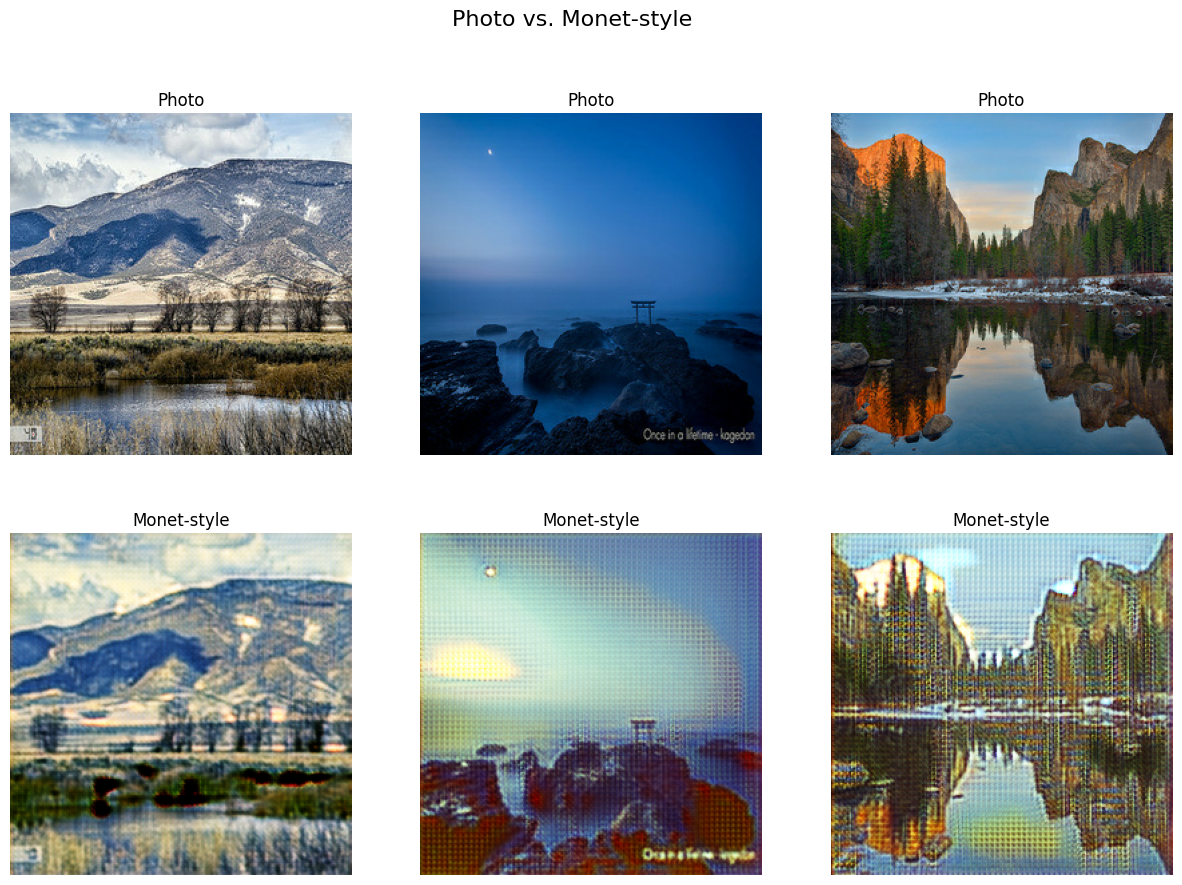

In [16]:
# Extract generator_monet
generator_monet =  CycleGan.GenM

# Visualize the Photos vs. Monet-style photos 
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
fig.suptitle('Photo vs. Monet-style', fontsize = 16)
for i, img in enumerate(photo_ds.take(3)):
    generated_img = generator_monet(img, training = False)[0].numpy()
    generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)
    img = tf.cast(img * 127.5 + 127.5, tf.uint8).numpy()
    img = np.squeeze(img, axis=0)
    ax[0, i].imshow(img)
    ax[0, i].set_title('Photo')
    ax[0, i].axis('off')
    ax[1, i].imshow(generated_img)
    ax[1, i].set_title('Monet-style')
    ax[1, i].axis('off')
plt.show()

The Monet-style photos already resemble paintings, even though we only trained the first model for 50 epochs. 

In [17]:
# Create the folder to save generated images
os.makedirs('../images/')

# Generate monet-style images
i = 1
for img in photo_ds:
    generated_img = generator_monet(img, training = False)[0].numpy()
    generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(generated_img)
    im.save("../images/" + str(i) + '.jpg')
    i += 1

print(f"Generated images: {len([name for name in os.listdir('../images') if os.path.isfile(os.path.join('../images', name))])}")

# archive the image folder
shutil.make_archive('/kaggle/working/images', 'zip', '../images')

Generated images: 7038


'/kaggle/working/images.zip'

### Reference  
Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros. Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. 2020. [arXiv:1703.10593](https://arxiv.org/abs/1703.10593) [cs.CV]

Amy Jang. Monet CycleGAN Tutorial. Kaggle Notebook. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook